

**Dataset and Preprocessing**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class TranslationDataset(Dataset):
    def __init__(self, file_path, max_len=10):
        self.pairs = []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    self.pairs.append((parts[0], parts[1]))
        self.max_len = max_len
        self.en_vocab, self.ar_vocab = self.build_vocab()

    def build_vocab(self):
        en_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
        ar_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
        for en, ar in self.pairs:
            for word in en.split():
                if word not in en_vocab:
                    en_vocab[word] = len(en_vocab)
            for word in ar.split():
                if word not in ar_vocab:
                    ar_vocab[word] = len(ar_vocab)
        return en_vocab, ar_vocab

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        en, ar = self.pairs[idx]
        en_seq = [self.en_vocab.get(word, 3) for word in en.split()] + [2]
        ar_seq = [1] + [self.ar_vocab.get(word, 3) for word in ar.split()] + [2]
        en_seq = en_seq[:self.max_len] + [0] * (self.max_len - len(en_seq))
        ar_seq = ar_seq[:self.max_len] + [0] * (self.max_len - len(ar_seq))
        return torch.tensor(en_seq), torch.tensor(ar_seq)

# Example usage
dataset = TranslationDataset('ara.txt')
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

**Define Models**

In [ ]:
import torch.nn as nn

class EncoderRNN(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(input_size, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

class DecoderRNN(nn.Module):
    def __init__(self, output_size, emb_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(output_size, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        outputs, hidden = self.rnn(embedded, hidden)
        predictions = self.fc(outputs)
        return predictions, hidden

class Seq2SeqRNN(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len = src.shape[0], trg.shape[1]
        trg_vocab_size = self.decoder.fc.out_features
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(src.device)
        _, hidden = self.encoder(src)
        input = trg[:, 0]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input.unsqueeze(1), hidden)
            outputs[:, t] = output.squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[:, t] if teacher_force else output.argmax(2).squeeze(1)
        return outputs

In [ ]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(input_size, emb_size)
        self.lstm = nn.LSTM(emb_size, hidden_size, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, (hidden, cell)

class DecoderLSTM(nn.Module):
    def __init__(self, output_size, emb_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(output_size, emb_size)
        self.lstm = nn.LSTM(emb_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_cell):
        embedded = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedded, hidden_cell)
        predictions = self.fc(outputs)
        return predictions, (hidden, cell)

class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len = src.shape[0], trg.shape[1]
        trg_vocab_size = self.decoder.fc.out_features
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(src.device)
        _, (hidden, cell) = self.encoder(src)
        input = trg[:, 0]
        for t in range(1, trg_len):
            output, (hidden, cell) = self.decoder(input.unsqueeze(1), (hidden, cell))
            outputs[:, t] = output.squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[:, t] if teacher_force else output.argmax(2).squeeze(1)
        return outputs

In [ ]:
class EncoderBiLSTM(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(input_size, emb_size)
        self.lstm = nn.LSTM(emb_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, hidden_size)  # Project concatenated states

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedded)
        hidden = self.fc(torch.cat((hidden[0], hidden[1]), dim=1)).unsqueeze(0)
        cell = self.fc(torch.cat((cell[0], cell[1]), dim=1)).unsqueeze(0)
        return outputs, (hidden, cell)

class Seq2SeqBiLSTM(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len = src.shape[0], trg.shape[1]
        trg_vocab_size = self.decoder.fc.out_features
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(src.device)
        _, (hidden, cell) = self.encoder(src)
        input = trg[:, 0]
        for t in range(1, trg_len):
            output, (hidden, cell) = self.decoder(input.unsqueeze(1), (hidden, cell))
            outputs[:, t] = output.squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[:, t] if teacher_force else output.argmax(2).squeeze(1)
        return outputs

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size)) # v should have the shape (hidden_size)

    def forward(self, hidden, encoder_outputs):
        batch_size, seq_len = encoder_outputs.shape[0], encoder_outputs.shape[1]
        hidden = hidden.repeat(seq_len, 1, 1).transpose(0, 1)  # hidden shape (batch_size, seq_len, hidden_size)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2))) # energy shape (batch_size, seq_len, hidden_size)
        # Change: use bmm for batched matrix multiplication and correct the shapes for self.v and energy
        attention = torch.softmax(torch.bmm(self.v.unsqueeze(0).unsqueeze(1).repeat(batch_size, 1, 1), energy.transpose(1, 2)), dim=2)
        context = torch.bmm(attention, encoder_outputs)  # Using batch matrix multiplication
        return context




class DecoderLSTMAttention(nn.Module):
    def __init__(self, output_size, emb_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(output_size, emb_size)
        self.lstm = nn.LSTM(emb_size + hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden_cell, encoder_outputs):
        # x: (batch_size, seq_len), e.g., (1, 1) during inference
        embedded = self.embedding(x)  # (batch_size, seq_len, emb_size)
        context = self.attention(hidden_cell[0], encoder_outputs)  # (batch_size, seq_len, hidden_size)
        lstm_input = torch.cat((embedded, context), dim=2)  # (batch_size, seq_len, emb_size + hidden_size)
        outputs, (hidden, cell) = self.lstm(lstm_input, hidden_cell)  # outputs: (batch_size, seq_len, hidden_size)
        predictions = self.fc(outputs)  # (batch_size, seq_len, output_size)
        return predictions, (hidden, cell)

class Seq2SeqLSTMAttention(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len = src.shape[0], trg.shape[1]
        trg_vocab_size = self.decoder.fc.out_features
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(src.device)
        encoder_outputs, (hidden, cell) = self.encoder(src)
        input = trg[:, 0]
        for t in range(1, trg_len):
            output, (hidden, cell) = self.decoder(input.unsqueeze(1), (hidden, cell), encoder_outputs)
            outputs[:, t] = output.squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[:, t] if teacher_force else output.argmax(2).squeeze(1)
        return outputs

**Split training and testing dataset**

In [ ]:
import torch.optim as optim
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = len(dataset.en_vocab)
output_size = len(dataset.ar_vocab)


def train(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for src, trg in dataloader:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        output = output[:, 1:].reshape(-1, output.shape[-1])
        trg = trg[:, 1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, teacher_forcing_ratio=0.0)  # No teacher forcing during validation
            output = output[:, 1:].reshape(-1, output.shape[-1])
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

# Common criterion
criterion = nn.CrossEntropyLoss(ignore_index=0)







**Training Models**

In [ ]:
# 1. Standard RNN
print("Training Standard RNN...")
rnn_enc = EncoderRNN(input_size, 256, 512).to(device)
rnn_dec = DecoderRNN(output_size, 256, 512).to(device)
rnn_model = Seq2SeqRNN(rnn_enc, rnn_dec).to(device)
rnn_optimizer = optim.Adam(rnn_model.parameters())

for epoch in range(10):
    train_loss = train(rnn_model, train_loader, rnn_optimizer, criterion, device)
    val_loss = validate(rnn_model, val_loader, criterion, device)
    print(f'RNN Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Training Standard RNN...
RNN Epoch 1, Train Loss: 7.3946, Val Loss: 7.3089
RNN Epoch 2, Train Loss: 6.5924, Val Loss: 7.4902
RNN Epoch 3, Train Loss: 6.1752, Val Loss: 7.5112
RNN Epoch 4, Train Loss: 5.8102, Val Loss: 7.7282
RNN Epoch 5, Train Loss: 5.5195, Val Loss: 7.8874
RNN Epoch 6, Train Loss: 5.2233, Val Loss: 7.9476
RNN Epoch 7, Train Loss: 5.0458, Val Loss: 8.2031
RNN Epoch 8, Train Loss: 4.9153, Val Loss: 8.2223
RNN Epoch 9, Train Loss: 4.6921, Val Loss: 8.3944
RNN Epoch 10, Train Loss: 4.5380, Val Loss: 8.5093


In [ ]:
# 2. LSTM
print("\nTraining LSTM...")
lstm_enc = EncoderLSTM(input_size, 256, 512).to(device)
lstm_dec = DecoderLSTM(output_size, 256, 512).to(device)
lstm_model = Seq2SeqLSTM(lstm_enc, lstm_dec).to(device)
lstm_optimizer = optim.Adam(lstm_model.parameters())

for epoch in range(10):
    train_loss = train(lstm_model, train_loader, lstm_optimizer, criterion, device)
    val_loss = validate(lstm_model, val_loader, criterion, device)
    print(f'LSTM Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Training LSTM...
LSTM Epoch 1, Train Loss: 7.0669, Val Loss: 6.7462
LSTM Epoch 2, Train Loss: 6.0641, Val Loss: 6.5356
LSTM Epoch 3, Train Loss: 5.2958, Val Loss: 6.4576
LSTM Epoch 4, Train Loss: 4.4435, Val Loss: 6.4005
LSTM Epoch 5, Train Loss: 3.5653, Val Loss: 6.5168
LSTM Epoch 6, Train Loss: 2.6816, Val Loss: 6.5489
LSTM Epoch 7, Train Loss: 1.9031, Val Loss: 6.7017
LSTM Epoch 8, Train Loss: 1.2797, Val Loss: 6.8456
LSTM Epoch 9, Train Loss: 0.8720, Val Loss: 6.9462
LSTM Epoch 10, Train Loss: 0.6036, Val Loss: 7.1053


In [ ]:
# 3. Bidirectional LSTM
print("\nTraining Bidirectional LSTM...")
bilstm_enc = EncoderBiLSTM(input_size, 256, 512).to(device)
bilstm_dec = DecoderLSTM(output_size, 256, 512).to(device)  # Reusing LSTM decoder
bilstm_model = Seq2SeqBiLSTM(bilstm_enc, bilstm_dec).to(device)
bilstm_optimizer = optim.Adam(bilstm_model.parameters())

for epoch in range(10):
    train_loss = train(bilstm_model, train_loader, bilstm_optimizer, criterion, device)
    val_loss = validate(bilstm_model, val_loader, criterion, device)
    print(f'BiLSTM Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')



Training Bidirectional LSTM...
BiLSTM Epoch 1, Train Loss: 7.0664, Val Loss: 6.7307
BiLSTM Epoch 2, Train Loss: 6.1055, Val Loss: 6.6455
BiLSTM Epoch 3, Train Loss: 5.4527, Val Loss: 6.5284
BiLSTM Epoch 4, Train Loss: 4.7510, Val Loss: 6.5453
BiLSTM Epoch 5, Train Loss: 3.9975, Val Loss: 6.5920
BiLSTM Epoch 6, Train Loss: 3.2760, Val Loss: 6.6533
BiLSTM Epoch 7, Train Loss: 2.5734, Val Loss: 6.8298
BiLSTM Epoch 8, Train Loss: 1.9083, Val Loss: 6.9831
BiLSTM Epoch 9, Train Loss: 1.3704, Val Loss: 7.0768
BiLSTM Epoch 10, Train Loss: 0.9683, Val Loss: 7.2424


In [ ]:

# 4. LSTM with Attention
print("\nTraining LSTM with Attention...")
attn_enc = EncoderLSTM(input_size, 256, 512).to(device)  # Reusing LSTM encoder
attn_dec = DecoderLSTMAttention(output_size, 256, 512).to(device)
attn_model = Seq2SeqLSTMAttention(attn_enc, attn_dec).to(device)
attn_optimizer = optim.Adam(attn_model.parameters())

for epoch in range(10):
    train_loss = train(attn_model, train_loader, attn_optimizer, criterion, device)
    val_loss = validate(attn_model, val_loader, criterion, device)
    print(f'Attention LSTM Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Training LSTM with Attention...
Attention LSTM Epoch 1, Train Loss: 7.0173, Val Loss: 6.7063
Attention LSTM Epoch 2, Train Loss: 6.1511, Val Loss: 6.5931
Attention LSTM Epoch 3, Train Loss: 5.4791, Val Loss: 6.4618
Attention LSTM Epoch 4, Train Loss: 4.6974, Val Loss: 6.3684
Attention LSTM Epoch 5, Train Loss: 3.8590, Val Loss: 6.4188
Attention LSTM Epoch 6, Train Loss: 2.9781, Val Loss: 6.4418
Attention LSTM Epoch 7, Train Loss: 2.1356, Val Loss: 6.5658
Attention LSTM Epoch 8, Train Loss: 1.4548, Val Loss: 6.7293
Attention LSTM Epoch 9, Train Loss: 0.9836, Val Loss: 6.8560
Attention LSTM Epoch 10, Train Loss: 0.6725, Val Loss: 6.9663


**Evaluation Models**

RNN BLEU Score: 0.0016
LSTM BLEU Score: 0.6323
BiLSTM BLEU Score: 0.5357
Attention BLEU Score: 0.6136


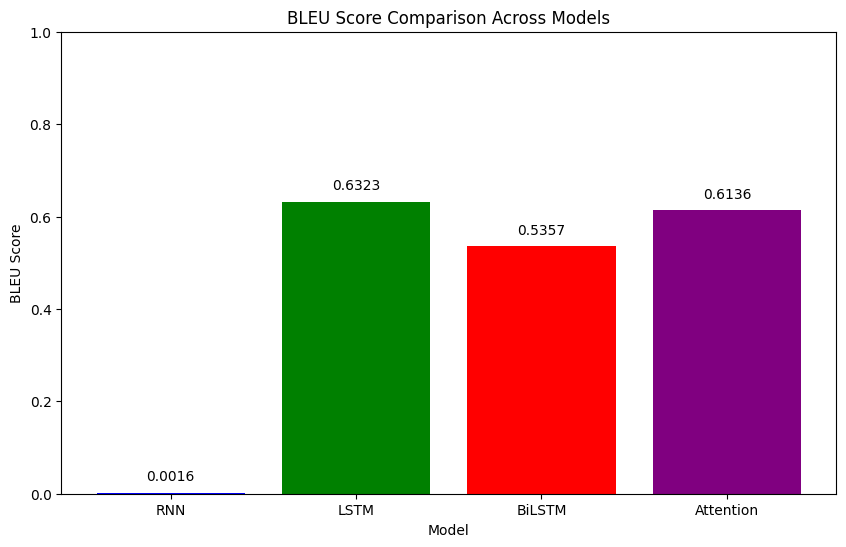

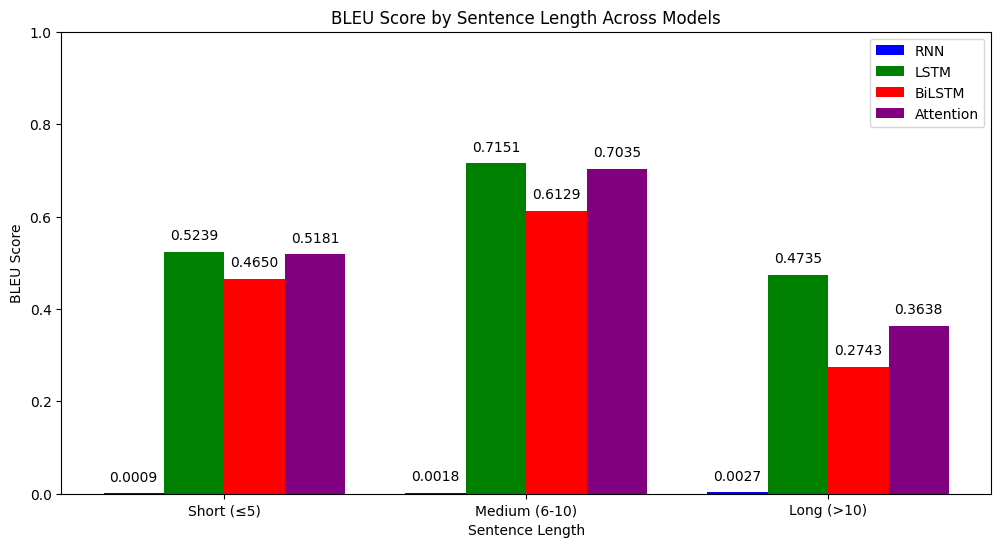

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import torch
import matplotlib.pyplot as plt


# Initialize dataset to get en_vocab and ar_vocab
dataset = TranslationDataset('ara.txt', max_len=10)
en_vocab = dataset.en_vocab
ar_vocab = dataset.ar_vocab


def translate_sentence(model, sentence, en_vocab, ar_vocab, device, max_len=10):
    model.eval()
    tokens = [en_vocab.get(word, en_vocab.get('<unk>', 3)) for word in sentence.split()] + [en_vocab['<eos>']]
    src = torch.tensor([tokens + [en_vocab['<pad>']] * (max_len - len(tokens))], device=device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src)
        if not isinstance(hidden, tuple):
            hidden_state = hidden  # RNN
        else:
            hidden_state = hidden  # LSTM or Attention (hidden, cell)

        trg_indexes = [ar_vocab['<sos>']]
        for _ in range(max_len):
            trg_tensor = torch.tensor([trg_indexes[-1]], device=device).unsqueeze(0)  # Shape: (1, 1)

            if hasattr(model.decoder, 'attention'):
                output, hidden_state = model.decoder(trg_tensor, hidden_state, encoder_outputs)
            elif isinstance(hidden_state, tuple):
                output, hidden_state = model.decoder(trg_tensor, hidden_state)
            else:
                output, hidden_state = model.decoder(trg_tensor, hidden_state)

            # Ensure output is 3D: (batch_size, seq_len, vocab_size)
            if output.dim() == 2:
                output = output.unsqueeze(1)  # Convert (1, vocab_size) to (1, 1, vocab_size)
            pred_token = output.argmax(2).item()

            trg_indexes.append(pred_token)
            if pred_token == ar_vocab['<eos>']:
                break

    return [list(ar_vocab.keys())[list(ar_vocab.values()).index(idx)] for idx in trg_indexes[1:-1]]

def compute_bleu(model, test_data, en_vocab, ar_vocab, device, max_len=10):
    references = [[pair[1].split()] for pair in test_data.dataset.pairs]
    hypotheses = []
    for pair in test_data.dataset.pairs:
        hyp = translate_sentence(model, pair[0], en_vocab, ar_vocab, device, max_len)
        hypotheses.append(hyp)
    return corpus_bleu(references, hypotheses)

def compute_bleu_by_length(model, test_data, en_vocab, ar_vocab, device, max_len=10):
    bins = {'short': ([], []), 'medium': ([], []), 'long': ([], [])}
    for pair in test_data.dataset.pairs:
        src_len = len(pair[0].split())
        ref = [pair[1].split()]
        hyp = translate_sentence(model, pair[0], en_vocab, ar_vocab, device, max_len)
        if src_len <= 5:
            bins['short'][0].append(ref)
            bins['short'][1].append(hyp)
        elif src_len <= 10:
            bins['medium'][0].append(ref)
            bins['medium'][1].append(hyp)
        else:
            bins['long'][0].append(ref)
            bins['long'][1].append(hyp)
    bleu_scores = {}
    for bin_name, (refs, hyps) in bins.items():
        bleu_scores[bin_name] = corpus_bleu(refs, hyps) if refs else 0.0
    return bleu_scores

# Evaluate all models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = {
    'RNN': rnn_model,
    'LSTM': lstm_model,
    'BiLSTM': bilstm_model,
    'Attention': attn_model
}
bleu_scores = {}
bleu_by_length = {}

for name, model in models.items():
    bleu_scores[name] = compute_bleu(model, test_data, en_vocab, ar_vocab, device)
    bleu_by_length[name] = compute_bleu_by_length(model, test_data, en_vocab, ar_vocab, device)
    print(f'{name} BLEU Score: {bleu_scores[name]:.4f}')

# Plot overall BLEU scores
plt.figure(figsize=(10, 6))
plt.bar(bleu_scores.keys(), bleu_scores.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('BLEU Score')
plt.title('BLEU Score Comparison Across Models')
plt.ylim(0, 1)
for i, (name, score) in enumerate(bleu_scores.items()):
    plt.text(i, score + 0.02, f'{score:.4f}', ha='center', va='bottom')
plt.savefig('bleu_comparison.png')
plt.show()

# Plot BLEU scores by sentence length
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = range(3)
colors = ['blue', 'green', 'red', 'purple']
length_bins = ['Short (≤5)', 'Medium (6-10)', 'Long (>10)']

for i, (name, scores) in enumerate(bleu_by_length.items()):
    bin_scores = [scores['short'], scores['medium'], scores['long']]
    plt.bar([x + bar_width * i for x in index], bin_scores, bar_width, label=name, color=colors[i])
    for j, score in enumerate(bin_scores):
        plt.text(j + bar_width * i, score + 0.02, f'{score:.4f}', ha='center', va='bottom')

plt.xlabel('Sentence Length')
plt.ylabel('BLEU Score')
plt.title('BLEU Score by Sentence Length Across Models')
plt.xticks([x + bar_width * 1.5 for x in index], length_bins)
plt.legend()
plt.ylim(0, 1)
plt.savefig('bleu_by_length.png')
plt.show()

In [ ]:

# Function to evaluate sample quality
def evaluate_sample_quality(models, test_data, en_vocab, ar_vocab, device, num_samples=3, max_len=10):
    """
    Evaluate the quality of translations for a few sample sentences.

    Args:
        models: Dictionary of model names and their corresponding models.
        test_data: Test dataset subset.
        en_vocab: English vocabulary dictionary.
        ar_vocab: Arabic vocabulary dictionary.
        device: PyTorch device (e.g., 'cuda' or 'cpu').
        num_samples: Number of sentences to evaluate (default: 3).
        max_len: Maximum length of the output sequence.

    Returns:
        None. Prints a table of source, reference, and predicted translations.
    """
    # Select samples: one short, one medium, one long
    samples = {'short': None, 'medium': None, 'long': None}
    for pair in test_data.dataset.pairs:
        src_len = len(pair[0].split())
        if src_len <= 5 and samples['short'] is None:
            samples['short'] = pair
        elif 6 <= src_len <= 10 and samples['medium'] is None:
            samples['medium'] = pair
        elif src_len > 10 and samples['long'] is None:
            samples['long'] = pair
        if all(samples.values()):
            break

    # Print table header
    print("\n=== Sample Quality Evaluation ===")
    print(f"{'Length':<10} {'Source':<20} {'Reference':<20} {'Model':<10} {'Prediction':<20}")
    print("=" * 80)

    # Evaluate each sample
    for length, (src, ref) in samples.items():
        print(f"{length:<10} {src:<20} {ref:<20} {'-':<10} {'-':<20}")  # Source and Reference
        for name, model in models.items():
            pred = translate_sentence(model, src, en_vocab, ar_vocab, device, max_len)
            pred_sentence = " ".join(pred)
            print(f"{'':<10} {'':<20} {'':<20} {name:<10} {pred_sentence:<20}")
        print("-" * 80)



# Add sample quality evaluation
evaluate_sample_quality(models, test_data, en_vocab, ar_vocab, device, num_samples=3, max_len=10)


=== Sample Quality Evaluation ===
Length     Source               Reference            Model      Prediction          
short      Hi.                  مرحبًا.              -          -                   
                                                     RNN        توم                 
                                                     LSTM       مرحبًا.             
                                                     BiLSTM     مرحبًا.             
                                                     Attention  مرحبًا.             
--------------------------------------------------------------------------------
medium     He is a man of wit.  هو رجل حكمة.         -          -                   
                                                     RNN        ماذا تريد أن تأكل؟  
                                                     LSTM       إنه يتحدث من غبار   
                                                     BiLSTM     إنه ماهر للامتحان.  
                                  